In this notebook we build a detailed comparison between the old and the new model

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_w_ind.pkl", "rb") as f:
    clf_w_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_wo_ind.pkl", "rb") as f:
    clf_wo_ind = pkl.load(f)
with open("../../artifacts/refitting-202021Q1/customer_risk_target_no_giact_time_since_last_link.pkl", "rb") as f:
    prev_model = pkl.load(f)

In [3]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored_w_scaled_by_bads.parquet"))

In [4]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [97]:
def build_indeterminate(df):
    return ((pd.to_datetime(df["dtc"]) <= df["sample_date"])
            | (df["last_unrestricted_date"] <= df["sample_date"])
            | (df["chg_wrt_off_date"] <= df["sample_date"])
            | (df["target"] & (df["latest_acc_bal"] > 0))
            | (
                ~df["target"] & (~df["chg_wrt_off_date"].isna())
                | (df["latest_acc_bal"] < 0)
                | (
                    df["closed_reason"].isin(
                        [
                            "Closed by SoFi - Risk Request",
                            "Closed by SoFi - Charge-Off / Write-Off",
                        ]
                    )
                )
                | (df["restricted_reason"].str.startswith("No"))
            ))

train_df["indeterminate"] = build_indeterminate(train_df)
test_df["indeterminate"] = build_indeterminate(test_df)

In [100]:
train_df[["indeterminate", "target"]].value_counts(normalize=True).sort_index()

indeterminate  target
False          False     0.933879
               True      0.002911
True           False     0.032845
               True      0.030365
dtype: float64

In [101]:
test_df[["indeterminate", "target"]].value_counts(normalize=True).sort_index()

indeterminate  target
False          False     0.910684
               True      0.001036
True           False     0.078271
               True      0.010008
dtype: float64

In [69]:
test_df.target.value_counts(normalize=True)

False    0.988956
True     0.011044
Name: target, dtype: float64

### Refitted Model - original Method

#### Decile and top percentiles 

In [75]:
def model_vs_baseline(modeling_df, percentiles, target_col_name, pred_col_name, base_col_name):
    """ Model vs Baseline """
    df = []
    percentiles = percentiles[::-1]  # flip the ordering
    for (bthresh, pctl), (mthresh, pctl) in zip([(np.percentile(modeling_df[base_col_name], pctl), pctl) for pctl in percentiles], 
                                                [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[base_col_name] >= bthresh]['target'].mean() * 100
        
        df.append([pctl, bthresh, mthresh, fbr, mbr])
        
    cols = ['Percentile', 'Baseline Threshold', 'Model Score Treshold', 'Baseline Bad Rate (%)', 'Model Bad Rate (%)']
    # also add target counts, etc
    return pd.DataFrame(df, columns=cols)

In [76]:
tbl_decile = model_vs_baseline(test_df,
                       np.linspace(0,100,11), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")

In [77]:
tbl_top = model_vs_baseline(test_df,
               np.linspace(90,99,10), 
               "target",
               "score_20201130_wo_ind",
               "score_20191231")
tbl_top

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,99.0,698.834409,725.140216,22.233912,5.488339
1,98.0,691.785324,716.708232,13.459009,3.682595
2,97.0,687.729122,712.515474,9.878419,2.998597
3,96.0,684.778926,709.520279,8.018413,2.586585
4,95.0,682.338574,707.189483,6.835479,2.332269
5,94.0,680.180430,705.158460,6.000292,2.107263
6,93.0,678.165862,703.370497,5.416103,1.951501
7,92.0,676.328364,701.715632,4.947391,1.814993
8,91.0,674.649914,700.210861,4.547669,1.712682
9,90.0,673.105060,698.768557,4.234985,1.609820


#### Segmented Performance
---

Active segment

In [78]:
df_ = test_df[test_df.is_active]
tbl_decile = model_vs_baseline(df_,
                       np.linspace(0,100,11), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,100.0,817.960197,850.000000,100.000000,0.000000
1,90.0,623.088679,585.864071,19.064597,13.863255
2,80.0,588.798541,557.437582,11.598154,9.338297
3,70.0,556.569682,537.941319,8.452477,7.176565
4,60.0,525.281710,522.750234,6.656529,5.919828
5,50.0,497.054459,509.088699,5.434258,5.004300
6,40.0,471.993607,495.618478,4.582794,4.327612
7,30.0,449.864961,481.163375,3.949064,3.808240
8,20.0,428.780797,463.714122,3.469883,3.397785
9,10.0,404.574391,437.198631,3.087822,3.068014


In-active

In [79]:
df_ = test_df[~test_df.is_active]
tbl_decile = model_vs_baseline(df_,
                       np.linspace(0,100,11), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,100.0,834.651060,841.749872,100.000000,100.000000
1,90.0,675.178879,700.939110,2.907981,1.349758
2,80.0,663.686581,690.423770,1.956222,1.009697
3,70.0,653.278827,680.213666,1.586321,0.893534
4,60.0,640.950263,664.492742,1.392947,0.845454
5,50.0,625.929035,642.366128,1.249126,0.802709
6,40.0,607.215113,620.215309,1.126222,0.768245
7,30.0,583.993992,597.717419,1.019782,0.763182
8,20.0,554.131654,572.370811,0.930476,0.784653
9,10.0,504.079553,536.591706,0.847680,0.797610


The old model is definitely better in terms of bad rate for the refitted model on both segments. Again, this is because this model failed to catch a few bads at absolutely the top. Dragging the performances down entirely.

### Refitted Model - modified targets

In [80]:
test_df.columns[test_df.columns.str.contains("score")]

Index(['fico_score', 'vantage_score', 'fraud_score_1', 'fraud_score_2',
       'address_risk_score', 'email_risk_score', 'phone_risk_score',
       'score_20191231', 'score_20201130_wo_ind', 'score_20201130_w_ind',
       'score_rescaled_20201130_w_ind',
       'score_rescaled_20201130_w_ind_bad_rate'],
      dtype='object')

In [81]:
tbl_decile = model_vs_baseline(test_df,
                       np.linspace(0,100,11), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")

In [84]:
tbl_top = model_vs_baseline(test_df,
               np.linspace(90,99,10), 
               "target",
               "score_rescaled_20201130_w_ind_bad_rate",
               "score_20191231")
tbl_top

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,99.0,698.834409,710.901624,22.233912,45.607575
1,98.0,691.785324,702.241848,13.459009,28.066637
2,97.0,687.729122,697.772974,9.878419,20.779752
3,96.0,684.778926,694.967937,8.018413,17.075844
4,95.0,682.338574,692.937011,6.835479,14.624908
5,94.0,680.180430,691.164596,6.000292,12.830630
6,93.0,678.165862,689.595187,5.416103,11.463500
7,92.0,676.328364,688.342879,4.947391,10.330995
8,91.0,674.649914,687.057522,4.547669,9.399295
9,90.0,673.105060,685.857557,4.234985,8.615520


#### Segmented Performance
---

Active segment

In [86]:
df_ = test_df[test_df.is_active]
tbl_decile = model_vs_baseline(df_,
                       np.linspace(0,100,11), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,100.0,817.960197,850.000000,100.000000,100.000000
1,90.0,623.088679,699.947760,19.064597,22.409815
2,80.0,588.798541,689.922301,11.598154,12.819841
3,70.0,556.569682,679.440960,8.452477,8.913902
4,60.0,525.281710,659.012893,6.656529,6.834806
5,50.0,497.054459,610.025522,5.434258,5.522347
6,40.0,471.993607,563.373935,4.582794,4.610760
7,30.0,449.864961,514.177808,3.949064,3.959551
8,20.0,428.780797,474.082126,3.469883,3.471194
9,10.0,404.574391,425.285872,3.087822,3.090153


In-active

In [87]:
df_ = test_df[~test_df.is_active]
tbl_decile = model_vs_baseline(df_,
                       np.linspace(0,100,11), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,Baseline Bad Rate (%),Model Bad Rate (%)
0,100.0,834.651060,850.000000,100.000000,100.000000
1,90.0,675.178879,682.616911,2.907981,5.483260
2,80.0,663.686581,673.846091,1.956222,3.123848
3,70.0,653.278827,666.036329,1.586321,2.244013
4,60.0,640.950263,657.055766,1.392947,1.761451
5,50.0,625.929035,643.169480,1.249126,1.455489
6,40.0,607.215113,620.620290,1.126222,1.244143
7,30.0,583.993992,588.027540,1.019782,1.080548
8,20.0,554.131654,544.311772,0.930476,0.952323
9,10.0,504.079553,485.340892,0.847680,0.851189


### Put the info together

In [88]:
def model_vs_baseline_detailed(modeling_df, percentiles, target_col_name, pred_col_name, base_col_name, precision=2):
    """ Model vs Baseline """
    df = []
    percentiles = percentiles[::-1]  # flip the ordering
    for (bthresh, pctl), (mthresh, pctl) in zip([(np.percentile(modeling_df[base_col_name], pctl), pctl) for pctl in percentiles], 
                                                [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]):
        
        # targets above thresholds
        m_tgt = modeling_df[modeling_df[pred_col_name] >= mthresh]['target']
        b_tgt = modeling_df[modeling_df[base_col_name] >= bthresh]['target']
        
        mbr = round(m_tgt.mean() * 100, precision)  # bad rates
        bbr = round(b_tgt.mean() * 100, precision)
        
        mbad = m_tgt.value_counts().loc[True]  # number of bads
        bbad = b_tgt.value_counts().loc[True]        
        
        # indeterminate above thresholds
        m_ind = modeling_df[modeling_df[pred_col_name] >= mthresh]['indeterminate']
        b_ind = modeling_df[modeling_df[base_col_name] >= bthresh]['indeterminate']
        
        mir = round(m_ind.mean() * 100, precision)
        bir = round(b_ind.mean() * 100, precision)   
        mindc = m_ind.value_counts().loc[True]
        bindc = b_ind.value_counts().loc[True]
        
        # details like nr ach returns, negative balances among targets
        m_tgt = modeling_df[(modeling_df[pred_col_name] >= mthresh)]
        b_tgt = modeling_df[(modeling_df[base_col_name] >= bthresh)]
        
        m_tgt_ = m_tgt[m_tgt["target"]]
        b_tgt_ = b_tgt[b_tgt["target"]]
        
        mret = ((m_tgt_["nr_returns_in_next_90d"] > 0) 
                    & (m_tgt_["bal_after_90d"] <= 0)).value_counts().loc[True]
        bret = ((b_tgt_["nr_returns_in_next_90d"] > 0) 
                    & (b_tgt_["bal_after_90d"] <= 0)).value_counts().loc[True]
        
        mneg = (m_tgt_["bal_after_90d"] <= 0).value_counts().loc[True]
        bneg = (b_tgt_["bal_after_90d"] <= 0).value_counts().loc[True]
                
        # nr accounts
        assert(len(m_tgt) == len(b_tgt))
        nacct = len(m_tgt)
        
        df.append([pctl, round(bthresh, precision), round(mthresh, precision),
                   (bbr, mbr), (bbad, mbad), (bret, mret), (bneg, mneg), (bir, mir),
                   (bindc, mindc) ,nacct])
        
    cols = ['Percentile', 'Baseline Threshold', 'Model Score Treshold', 
            '(Baseline, Model) Bad Rate (%)', '(Baseline, Model) Targets Captured', 
            '(Baseline, Model) Nr user has returns Captured', '(Baseline, Model) Nr neg bal accts Captured',
            '(Baseline, Model) Ind above threshold (%)', '(Baseline, Model) Ind Counts', 'Nr accounts']
    # also add target counts, etc
    return pd.DataFrame(df, columns=cols)

### Incumbent vs Refit no change

In [89]:
tbl_decile = model_vs_baseline_detailed(test_df,
                       np.linspace(0,90,10), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,673.11,698.77,"(4.23, 1.61)","(2415, 918)","(569, 526)","(2004, 861)","(9.86, 7.93)","(5622, 4522)",57025
1,80.0,660.26,686.90,"(2.79, 1.18)","(3181, 1349)","(841, 713)","(2630, 1254)","(7.89, 5.03)","(8996, 5737)",114050
2,70.0,647.42,672.31,"(2.26, 1.1)","(3867, 1880)","(1049, 916)","(3141, 1733)","(7.67, 4.19)","(13121, 7162)",171075
3,60.0,631.63,648.18,"(1.99, 1.09)","(4540, 2487)","(1254, 1113)","(3628, 2245)","(8.16, 4.09)","(18621, 9326)",228099
4,50.0,612.46,622.02,"(1.79, 1.07)","(5090, 3050)","(1408, 1241)","(3989, 2689)","(8.42, 4.57)","(24009, 13041)",285124
5,40.0,588.86,596.54,"(1.63, 1.09)","(5574, 3745)","(1535, 1364)","(4289, 3144)","(8.17, 6.08)","(27948, 20819)",342149
6,30.0,560.32,569.42,"(1.48, 1.16)","(5907, 4615)","(1612, 1506)","(4497, 3715)","(7.95, 7.91)","(31751, 31591)",399173
7,20.0,518.63,536.92,"(1.35, 1.2)","(6168, 5474)","(1670, 1613)","(4657, 4246)","(8.36, 9.05)","(38146, 41299)",456198
8,10.0,465.05,499.13,"(1.22, 1.17)","(6267, 6027)","(1696, 1671)","(4708, 4570)","(9.12, 9.22)","(46806, 47303)",513223
9,0.0,300.00,300.00,"(1.1, 1.1)","(6298, 6298)","(1701, 1701)","(4722, 4722)","(8.83, 8.83)","(50341, 50341)",570248


In [90]:
df_ = test_df[test_df.is_active]
tbl_decile = model_vs_baseline_detailed(df_,
                       np.linspace(0,90,10), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,623.09,585.86,"(19.06, 13.86)","(1818, 1322)","(337, 338)","(1180, 934)","(47.18, 35.73)","(4499, 3407)",9536
1,80.0,588.80,557.44,"(11.6, 9.34)","(2212, 1781)","(430, 418)","(1403, 1186)","(33.66, 26.93)","(6420, 5137)",19072
2,70.0,556.57,537.94,"(8.45, 7.18)","(2418, 2053)","(482, 457)","(1528, 1337)","(24.5, 21.57)","(7010, 6171)",28607
3,60.0,525.28,522.75,"(6.66, 5.92)","(2539, 2258)","(509, 479)","(1603, 1452)","(19.56, 18.13)","(7459, 6915)",38143
4,50.0,497.05,509.09,"(5.43, 5.0)","(2591, 2386)","(523, 498)","(1633, 1516)","(16.2, 15.62)","(7725, 7449)",47679
5,40.0,471.99,495.62,"(4.58, 4.33)","(2622, 2476)","(532, 510)","(1647, 1564)","(13.92, 13.81)","(7963, 7899)",57214
6,30.0,449.86,481.16,"(3.95, 3.81)","(2636, 2542)","(534, 525)","(1655, 1607)","(12.47, 12.41)","(8323, 8283)",66750
7,20.0,428.78,463.71,"(3.47, 3.4)","(2647, 2592)","(535, 533)","(1659, 1632)","(11.46, 11.31)","(8746, 8628)",76285
8,10.0,404.57,437.20,"(3.09, 3.07)","(2650, 2633)","(536, 535)","(1661, 1651)","(10.5, 10.4)","(9009, 8926)",85821
9,0.0,300.00,300.00,"(2.78, 2.78)","(2653, 2653)","(537, 537)","(1662, 1662)","(9.58, 9.58)","(9138, 9138)",95357


In [91]:
df_ = test_df[~test_df.is_active]
tbl_decile = model_vs_baseline_detailed(df_,
                       np.linspace(0,90,10), 
                       "target",
                       "score_20201130_wo_ind",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,675.18,700.94,"(2.91, 1.35)","(1381, 641)","(393, 388)","(1254, 609)","(8.17, 8.09)","(3882, 3841)",47490
1,80.0,663.69,690.42,"(1.96, 1.01)","(1858, 959)","(576, 535)","(1679, 910)","(6.52, 5.07)","(6197, 4811)",94979
2,70.0,653.28,680.21,"(1.59, 0.89)","(2260, 1273)","(730, 679)","(2018, 1210)","(6.2, 4.01)","(8829, 5717)",142468
3,60.0,640.95,664.49,"(1.39, 0.85)","(2646, 1606)","(860, 815)","(2340, 1529)","(6.45, 3.62)","(12250, 6877)",189957
4,50.0,625.93,642.37,"(1.25, 0.8)","(2966, 1906)","(984, 925)","(2602, 1797)","(6.81, 3.61)","(16170, 8566)",237446
5,40.0,607.22,620.22,"(1.13, 0.77)","(3209, 2189)","(1061, 991)","(2782, 2042)","(6.84, 4.06)","(19494, 11557)",284935
6,30.0,583.99,597.72,"(1.02, 0.76)","(3390, 2537)","(1109, 1050)","(2903, 2279)","(6.64, 5.28)","(22087, 17544)",332424
7,20.0,554.13,572.37,"(0.93, 0.78)","(3535, 2981)","(1139, 1113)","(2994, 2596)","(6.73, 6.91)","(25565, 26236)",379913
8,10.0,504.08,536.59,"(0.85, 0.8)","(3623, 3409)","(1156, 1156)","(3048, 2903)","(7.71, 8.23)","(32956, 35164)",427402
9,0.0,300.00,327.60,"(0.77, 0.77)","(3645, 3645)","(1164, 1164)","(3060, 3060)","(8.68, 8.68)","(41203, 41203)",474891


### Incumbent vs. Refit - removed ind

In [92]:
tbl_decile = model_vs_baseline_detailed(test_df,
                       np.linspace(0,90,10), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,673.11,685.86,"(4.23, 8.62)","(2415, 4913)","(569, 934)","(2004, 3478)","(9.86, 31.47)","(5622, 17948)",57025
1,80.0,660.26,675.81,"(2.79, 4.79)","(3181, 5463)","(841, 1193)","(2630, 3958)","(7.89, 21.06)","(8996, 24018)",114050
2,70.0,647.42,667.01,"(2.26, 3.37)","(3867, 5766)","(1049, 1379)","(3141, 4239)","(7.67, 15.84)","(13121, 27097)",171075
3,60.0,631.63,657.19,"(1.99, 2.61)","(4540, 5953)","(1254, 1501)","(3628, 4414)","(8.16, 12.74)","(18621, 29049)",228099
4,50.0,612.46,641.20,"(1.79, 2.13)","(5090, 6084)","(1408, 1590)","(3989, 4536)","(8.42, 10.74)","(24009, 30630)",285124
5,40.0,588.86,614.09,"(1.63, 1.81)","(5574, 6188)","(1535, 1647)","(4289, 4630)","(8.17, 9.44)","(27948, 32299)",342149
6,30.0,560.32,578.69,"(1.48, 1.56)","(5907, 6236)","(1612, 1672)","(4497, 4671)","(7.95, 8.71)","(31751, 34772)",399173
7,20.0,518.63,529.30,"(1.35, 1.37)","(6168, 6267)","(1670, 1686)","(4657, 4694)","(8.36, 8.41)","(38146, 38352)",456198
8,10.0,465.05,473.74,"(1.22, 1.23)","(6267, 6289)","(1696, 1698)","(4708, 4715)","(9.12, 8.5)","(46806, 43626)",513223
9,0.0,300.00,334.56,"(1.1, 1.1)","(6298, 6298)","(1701, 1701)","(4722, 4722)","(8.83, 8.83)","(50341, 50341)",570248


In [93]:
df_ = test_df[test_df.is_active]
tbl_decile = model_vs_baseline_detailed(df_,
                       np.linspace(0,90,10), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,623.09,699.95,"(19.06, 22.41)","(1818, 2137)","(337, 390)","(1180, 1338)","(47.18, 45.3)","(4499, 4320)",9536
1,80.0,588.80,689.92,"(11.6, 12.82)","(2212, 2445)","(430, 476)","(1403, 1526)","(33.66, 31.61)","(6420, 6028)",19072
2,70.0,556.57,679.44,"(8.45, 8.91)","(2418, 2550)","(482, 512)","(1528, 1591)","(24.5, 24.48)","(7010, 7002)",28607
3,60.0,525.28,659.01,"(6.66, 6.83)","(2539, 2607)","(509, 523)","(1603, 1631)","(19.56, 19.41)","(7459, 7402)",38143
4,50.0,497.05,610.03,"(5.43, 5.52)","(2591, 2633)","(523, 530)","(1633, 1647)","(16.2, 16.05)","(7725, 7651)",47679
5,40.0,471.99,563.37,"(4.58, 4.61)","(2622, 2638)","(532, 531)","(1647, 1651)","(13.92, 13.83)","(7963, 7915)",57214
6,30.0,449.86,514.18,"(3.95, 3.96)","(2636, 2643)","(534, 533)","(1655, 1653)","(12.47, 12.29)","(8323, 8205)",66750
7,20.0,428.78,474.08,"(3.47, 3.47)","(2647, 2648)","(535, 535)","(1659, 1658)","(11.46, 11.18)","(8746, 8525)",76285
8,10.0,404.57,425.29,"(3.09, 3.09)","(2650, 2652)","(536, 536)","(1661, 1661)","(10.5, 10.32)","(9009, 8853)",85821
9,0.0,300.00,334.56,"(2.78, 2.78)","(2653, 2653)","(537, 537)","(1662, 1662)","(9.58, 9.58)","(9138, 9138)",95357


In [94]:
df_ = test_df[~test_df.is_active]
tbl_decile = model_vs_baseline_detailed(df_,
                       np.linspace(0,90,10), 
                       "target",
                       "score_rescaled_20201130_w_ind_bad_rate",
                       "score_20191231")
tbl_decile.to_csv("./artifacts/seg_perf_.csv")
tbl_decile

,Percentile,Baseline Threshold,Model Score Treshold,"(Baseline, Model) Bad Rate (%)","(Baseline, Model) Targets Captured","(Baseline, Model) Nr user has returns Captured","(Baseline, Model) Nr neg bal accts Captured","(Baseline, Model) Ind above threshold (%)","(Baseline, Model) Ind Counts",Nr accounts
0,90.0,675.18,682.62,"(2.91, 5.48)","(1381, 2604)","(393, 525)","(1254, 2086)","(8.17, 28.26)","(3882, 13421)",47490
1,80.0,663.69,673.85,"(1.96, 3.12)","(1858, 2967)","(576, 729)","(1679, 2425)","(6.52, 18.65)","(6197, 17718)",94979
2,70.0,653.28,666.04,"(1.59, 2.24)","(2260, 3197)","(730, 873)","(2018, 2641)","(6.2, 14.07)","(8829, 20047)",142468
3,60.0,640.95,657.06,"(1.39, 1.76)","(2646, 3346)","(860, 979)","(2340, 2783)","(6.45, 11.4)","(12250, 21654)",189957
4,50.0,625.93,643.17,"(1.25, 1.46)","(2966, 3456)","(984, 1056)","(2602, 2889)","(6.81, 9.67)","(16170, 22972)",237446
5,40.0,607.22,620.62,"(1.13, 1.24)","(3209, 3545)","(1061, 1109)","(2782, 2974)","(6.84, 8.53)","(19494, 24299)",284935
6,30.0,583.99,588.03,"(1.02, 1.08)","(3390, 3592)","(1109, 1138)","(2903, 3015)","(6.64, 7.9)","(22087, 26274)",332424
7,20.0,554.13,544.31,"(0.93, 0.95)","(3535, 3618)","(1139, 1151)","(2994, 3037)","(6.73, 7.69)","(25565, 29202)",379913
8,10.0,504.08,485.34,"(0.85, 0.85)","(3623, 3638)","(1156, 1161)","(3048, 3054)","(7.71, 7.94)","(32956, 33919)",427402
9,0.0,300.00,346.02,"(0.77, 0.77)","(3645, 3645)","(1164, 1164)","(3060, 3060)","(8.68, 8.68)","(41203, 41203)",474891


### Plot Model Performances with Indeterminates Removed!!!!

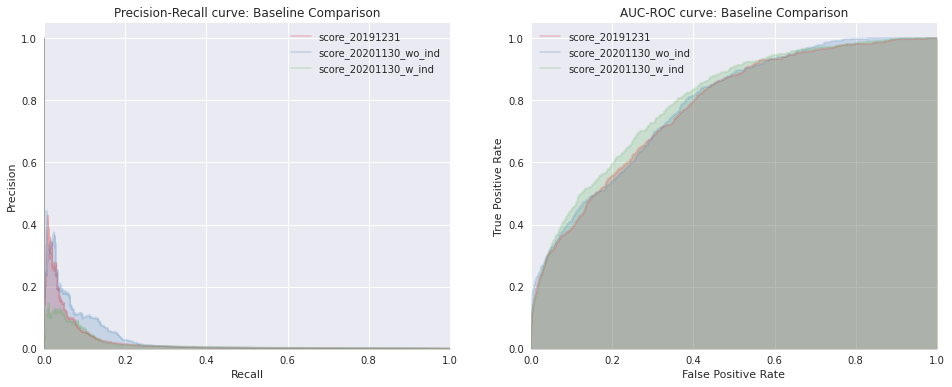

In [72]:
score_cols = ['score_20191231', 
              'score_20201130_wo_ind', 
              'score_20201130_w_ind']

mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"20201201": test_df[~test_df.indeterminate]}, "target", score_cols, mntr_path, dropna=False
    )

In [73]:
test_df.indeterminate.value_counts(normalize=True)

False    0.911721
True     0.088279
Name: indeterminate, dtype: float64

In [96]:
test_df[["indeterminate", "is_active"]].value_counts().sort_index()

indeterminate  is_active
False          False        433688
               True          86219
True           False         41203
               True           9138
dtype: int64